In [37]:
import numpy.random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=":")
    if len(args)==3:
        fig_ax.legend(loc=args[2])

In [39]:
rd.seed(71)

T = 500
v_sd = 20 # 観測誤差の標準偏差
i_sd = 10 # interceptの標準偏差
a10 = 10
e_sd1 = .5 # 回帰係数1の変動の標準偏差
a20 = 20
e_sd2 = .8 # 回帰係数1の変動の標準偏差

# 時変回帰係数２つ
e1 = np.random.normal(0, e_sd1, size=T)
a1 = e1.cumsum() + a10
e2 = np.random.normal(0, e_sd2, size=T)
a2 = e2.cumsum() + a20

# intercept
intercept = np.cumsum(np.random.normal(0, i_sd, size=T))

# 説明変数
x1 = rd.normal(10, 10, size=T)
x2 = rd.normal(10, 10, size=T)

# 被説明変数
v = np.random.normal(0, v_sd, size=T) # 観測誤差
y = intercept + a1*x1 + a2*x2 + v
y_noerror = intercept + a1*x1 + a2*x2  # 観測誤差がなかった時の　y


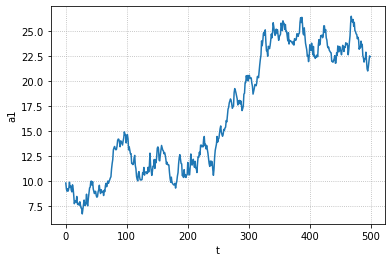

In [40]:
fig, ax = plt.subplots()
t = np.arange(T)
ax.plot(t,a1)
plot_set(ax,"t","a1")

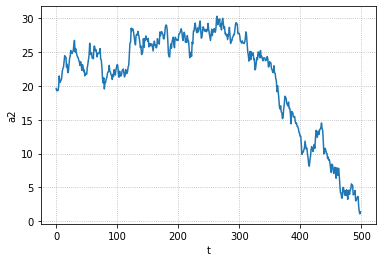

In [41]:
fig, ax = plt.subplots()
ax.plot(t,a2)
plot_set(ax,"t","a2")

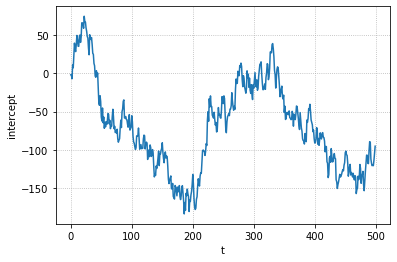

In [42]:
fig, ax = plt.subplots()
ax.plot(t,intercept)
plot_set(ax,"t","intercept")

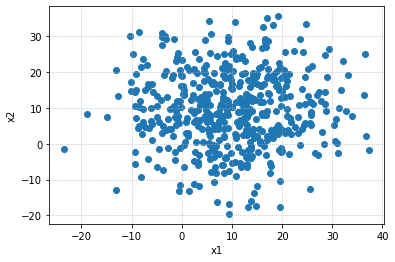

In [43]:
fig, ax = plt.subplots()
ax.scatter(x1,x2)
plot_set(ax,"x1","x2")

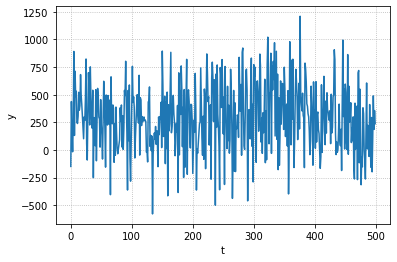

In [44]:
fig, ax = plt.subplots()
ax.plot(t,y)
plot_set(ax,"t","y")

In [45]:
df = pd.DataFrame({"x1":x1, "x2":x2, "y":y, "a1":a1,  "a2":a2, "intercept":intercept})
df.head()

,x1,x2,y,a1,a2,intercept
0,-6.768232,-4.238996,-149.547649,9.784698,19.610076,-2.215152
1,10.001302,16.760184,438.058268,9.187734,19.249373,-2.804606
2,8.388453,4.014684,150.659873,8.965585,19.348741,-7.342012
3,-6.030999,1.090963,-16.883775,9.210291,19.297976,10.552154
4,23.608283,-0.249615,226.788912,8.984512,19.822178,6.933788


In [46]:
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.rinterface import R_VERSION_BUILD
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [47]:
def get_method(result, method_name):
    """Rの関数の戻り値で取得したオブジェクトの関数を取り出す
    result: Rの関数の戻り値で取得したオブジェクト
    method_name: 取り出したいメソッドの名称
    """
    for i in result.items():
        if i[0] == method_name:
            return i[1]
    assert False

In [48]:
def show_result(result):
    """Rの関数の戻り値で取得したオブジェクトの関数を取り出す
    result: Rの関数の戻り値で取得したオブジェクト
    method_name: 取り出したいメソッドの名称
    """
    for i in result.items():
        print(i[0], i[1], )

In [49]:
dlm = importr("dlm")

In [50]:
buildDlmReg = lambda theta: dlm.dlmModReg(
    X=df[["x1", "x2"]], 
    dV=np.exp(theta[0]), 
    dW=[np.exp(theta[1]), np.exp(theta[2]), np.exp(theta[3])]
  )

In [51]:
# 2段階で最尤推定を行う
parm = dlm.dlmMLE(y, parm=[2, 1, 1, 1], build=buildDlmReg, method="L-BFGS-B") 
par = np.array(get_method(parm, "par"))
print("par:", par)
fitDlmReg = dlm.dlmMLE(y, parm=par, build=buildDlmReg, method="SANN")

par: [ 5.99988463  4.57242133 -1.65722425 -0.92329885]


In [52]:
show_result(fitDlmReg)

par [1]  5.9998846  4.5724213 -1.6572242 -0.9232988

value [1] 2017.984

counts function gradient 
   10000       NA 

convergence [1] 0

message NULL


In [53]:
# 収束確認(0ならOK)
convergence = get_method(fitDlmReg, "convergence")
print("convergence:", convergence[0])

convergence: 0


In [54]:
par = np.asanyarray(get_method(fitDlmReg, "par"))
modDlmReg = buildDlmReg(par)

In [66]:
#show_result(modDlmReg)

In [56]:
estimated_sd = np.sqrt(np.exp(np.array(get_method(fitDlmReg, "par"))))

pd.DataFrame({"estimated_sd":estimated_sd, "sd":[v_sd, i_sd, e_sd1, e_sd2]})

,estimated_sd,sd
0,20.084378,20.0
1,9.837589,10.0
2,0.436655,0.5
3,0.630243,0.8


In [57]:
# カルマンフィルタ
filterDlmReg = dlm.dlmFilter(y, modDlmReg)

# スムージング
smoothDlmReg = dlm.dlmSmooth(filterDlmReg)

In [65]:
#show_result(filterDlmReg)

In [59]:
filtered_a = np.array(get_method(filterDlmReg, "a"))
smoothed_a = np.array(get_method(smoothDlmReg, "s"))

Text(0.5, 1.0, 'plot of intercept')

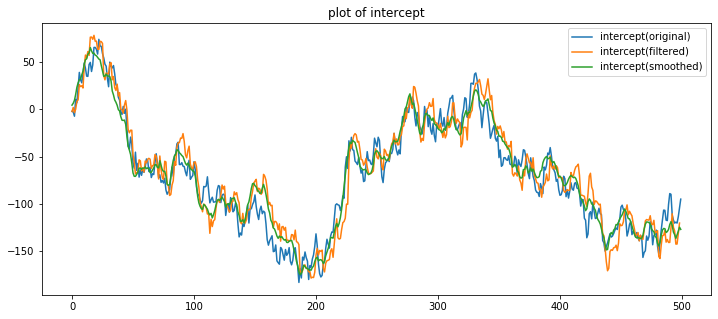

In [60]:
plt.figure(figsize=(12,5))
plt.plot(df.intercept, label="intercept(original)")
plt.plot(filtered_a[1:,0], label="intercept(filtered)")
plt.plot(smoothed_a[1:,0], label="intercept(smoothed)")
plt.legend(loc="best")
plt.title("plot of intercept")

Text(0.5, 1.0, 'plot of regression coeff a1')

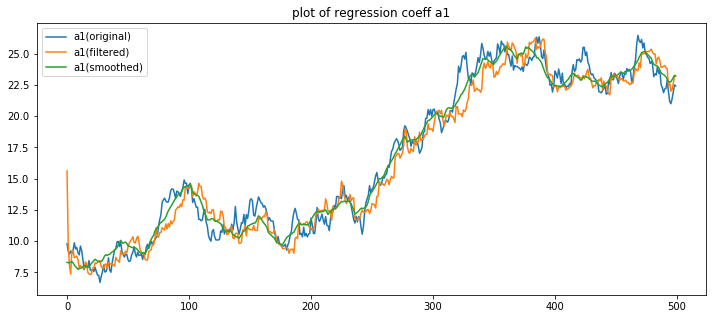

In [61]:
plt.figure(figsize=(12,5))
plt.plot(df.a1, label="a1(original)")
plt.plot(filtered_a[1:,1], label="a1(filtered)")
plt.plot(smoothed_a[1:,1], label="a1(smoothed)")
plt.legend(loc="best")
plt.title("plot of regression coeff a1")

Text(0.5, 1.0, 'plot of regression coeff a2')

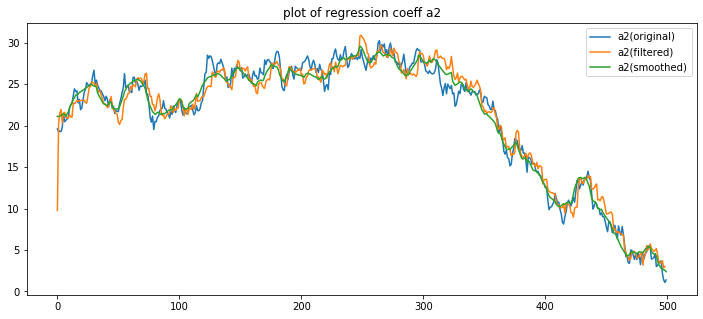

In [62]:
plt.figure(figsize=(12,5))
plt.plot(df.a2, label="a2(original)")
plt.plot(filtered_a[1:,2], label="a2(filtered)")
plt.plot(smoothed_a[1:,2], label="a2(smoothed)")
plt.legend(loc="best")
plt.title("plot of regression coeff a2")

In [63]:
estimatedLevel = smoothed_a[1:,0] + df.x1*smoothed_a[1:,1] + df.x2*smoothed_a[1:,2]

Text(0.5, 1.0, 'plot of target value.')

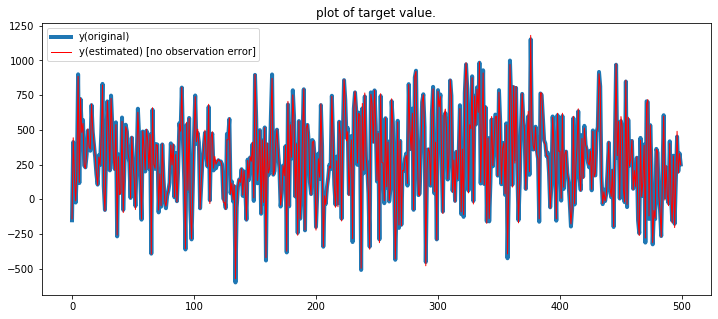

In [64]:
plt.figure(figsize=(12,5))
plt.plot(y_noerror, lw=4, label="y(original)")
plt.plot(estimatedLevel, "r", lw=1, label="y(estimated) [no observation error]")
plt.legend(loc="best")
plt.title("plot of target value.")